# QuaNNTO Example — Curve Fitting with CV-QONNs (multi-mode sweep)

This notebook is an **end-to-end example** for the `QuaNNTO` library.

It:
1. Generates (or loads) a noisy training dataset for a target function.
2. Builds validation and test sets (noise-free).
3. Trains multiple CV-QONN models while **sweeping the number of modes** `N`.
4. Evaluates each trained model on the test set.
5. Saves training/validation curves and test predictions.
6. Plots a joint comparison of all models.

---
## Requirements
- Run this notebook from the **root of the QuaNNTO repository** (or install it in editable mode).
- The script uses internal modules:
  - `quannto.core.qnn_trainers`
  - `quannto.dataset_gens.synthetic_datasets`
  - `quannto.core.data_processors`
  - `quannto.core.loss_functions`
  - `quannto.utils.results_utils`

### Notes
- Output folders are created automatically (`datasets/` and `quannto/tasks/...`).

In [1]:
import sys
from pathlib import Path

# set repo_root to the parent directory to find 'quannto' modules
repo_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(repo_root))

In [2]:
from functools import partial
import numpy as np
import os

from quannto.core.qnn_trainers import *
from quannto.dataset_gens.synthetic_datasets import *
from quannto.utils.results_utils import *
from quannto.core.data_processors import *
from quannto.core.loss_functions import *

np.random.seed(42)

2026-02-19 20:36:38.952764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 20:36:38.952874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 20:36:38.956060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-19 20:36:41.132299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) Hyperparameters

We train and compare three models with different mode counts:
- `N = 2, 3, 4`

Each model uses one non-Gaussian event pattern (`qnns_ladder_modes`) and one layer (`qnns_layers`).

The input is rescaled to `(-3, 3)` and padded to length `2N`.
The outputs are optionally rescaled to `(1, 3)` and mapped back to the original output range after inference.

In [3]:
# === HYPERPARAMETERS DEFINITION ===
qnns_modes = [2, 3, 4]
qnns_ladder_modes = [[[1]], [[1, 2]], [[1, 2, 3]]]
qnns_layers = [1, 1, 1]

# Photon addition (True) or subtraction (False)
qnns_is_addition = [False, False, False]

include_initial_squeezing = False
include_initial_mixing = False
is_passive_gaussian = False

n_inputs = 1
n_outputs = 1
observable = 'position'

# in_norm_ranges = [None]*len(qnns_modes)  # or explicit ranges (a, b)
in_norm_ranges = [(-3, 3)] * len(qnns_modes)

# out_norm_ranges = [None]*len(qnns_modes)  # or explicit ranges (a, b)
out_norm_ranges = [(1, 3)] * len(qnns_modes)

## 2) Optimizer settings

This example uses:
- `build_and_train_model` as the training entry point
- Mean squared error (`mse`) as the loss
- A small number of basinhopping iterations for a quick demo

You can increase `basinhopping_iters` for more thorough optimization.

In [4]:
# === OPTIMIZER SETTINGS ===
optimize = build_and_train_model
loss_function = mse

# For reproducible & fast example runs; increase for better fits.
basinhopping_iters = 4

# Optional initial parameters; None lets the trainer initialize.
params = None

## 3) Dataset generation (target function)

We define a curve-fitting task using `trig_fun` function from `quannto/dataset_gens/synthetic_datasets`.

- Training set: random samples + Gaussian noise
- Validation set: random samples, noise-free
- Test set: linearly spaced samples, noise-free

The training dataset is cached to disk under `datasets/` so repeated runs reuse the same noisy training data.

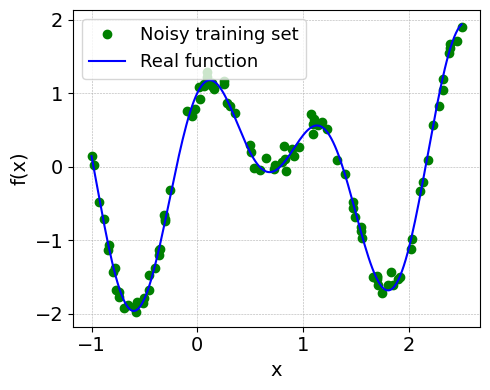

In [5]:
# === DATASET (TARGET FUNCTION) SETTINGS ===
from quannto.utils.path_utils import datasets_dir


target_function = trig_fun
input_range = (-1, 2.5)

trainset_noise = 0.1
trainset_size = 100
testset_size = 200
validset_size = 50

task_name = (
    f"curvefitting_{target_function.__name__}"
    f"_trainsize{trainset_size}_noise{trainset_noise}"
    f"_rng{input_range[0]}to{input_range[1]}"
)

dataset_dir = str(datasets_dir() / task_name)

# 1) TRAINING DATASET (noisy): load or generate
inputs_path = f"{dataset_dir}_inputs.npy"
outputs_path = f"{dataset_dir}_outputs.npy"

if os.path.isfile(inputs_path) and os.path.isfile(outputs_path):
    with open(inputs_path, "rb") as f:
        inputs = np.load(f)
    with open(outputs_path, "rb") as f:
        outputs = np.load(f)
    train_dataset = [inputs, outputs]
else:
    train_dataset = generate_noisy_samples(
        trainset_size,
        target_function,
        input_range[0],
        input_range[1],
        trainset_noise,
    )
    with open(inputs_path, "wb") as f:
        np.save(f, train_dataset[0])
    with open(outputs_path, "wb") as f:
        np.save(f, train_dataset[1])

# Update input range to match actual sampled training inputs
input_range = (np.min(train_dataset[0]), np.max(train_dataset[0]))

# 2) VALIDATION DATASET (noise-free): random samples (set to None to disable validation)
valid_dataset = generate_dataset_of(target_function, n_inputs, n_outputs, validset_size, input_range)

# 3) TEST DATASET (noise-free): linear samples
test_dataset = generate_linear_dataset_of(target_function, n_inputs, n_outputs, testset_size, input_range)

# Plot noisy training samples + clean target curve
plot_noisy_dataset(task_name, train_dataset, test_dataset)

## 4) Build, train, test (sweep over number of modes)

For each configuration `(N, L, ladder_modes, is_addition, in_norm_range, out_norm_range)`:
- Define a unique `model_name` used for saving results.
- Create preprocessors/postprocessors.
- Train the model.
- Evaluate on the test set.

In [6]:
qnns = []
train_losses = []
valid_losses = []
qnns_preds = []
legend_labels = []

for (N, l, ladder_modes, is_addition, in_norm_range, out_norm_range) in zip(
    qnns_modes,
    qnns_layers,
    qnns_ladder_modes,
    qnns_is_addition,
    in_norm_ranges,
    out_norm_ranges,
):
    # === NAME AND LEGEND OF THE QONN MODEL ===
    model_name = (
        task_name
        + "_N" + str(N)
        + "_L" + str(l)
        + ("_add" if is_addition else "_sub")
        + str(ladder_modes)
        + "_in" + str(in_norm_range)
        + "_out" + str(out_norm_range)
    )

    # Non-Gaussian operator label (Matplotlib/LaTeX-friendly)
    nongauss_op = r"$\hat a^\dagger$" if is_addition else r"$\hat a$"
    legend_labels.append(
        f"N={N}, L={l}, {nongauss_op} in modes {np.array(ladder_modes[0]) + 1}"
    )

    # === PREPROCESSORS AND POSTPROCESSORS ===
    in_preprocessors = []
    if in_norm_range is not None:
        in_preprocessors.append(
            partial(rescale_data, data_range=input_range, scale_data_range=in_norm_range)
        )
    # Pad input vector to match internal 2N representation
    in_preprocessors.append(partial(pad_data, length=2 * N))

    out_preprocessors = []
    postprocessors = []
    if out_norm_range is not None:
        output_range = get_range(test_dataset[1])
        out_preprocessors.append(
            partial(rescale_data, data_range=output_range, scale_data_range=out_norm_range)
        )
        postprocessors.append(
            partial(rescale_data, data_range=out_norm_range, scale_data_range=output_range)
        )

    # === BUILD, TRAIN AND TEST QNN ===
    qnn, train_loss, valid_loss = optimize(
        model_name,
        task_name,
        N,
        l,
        n_inputs,
        n_outputs,
        ladder_modes,
        is_addition,
        observable,
        include_initial_squeezing,
        include_initial_mixing,
        is_passive_gaussian,
        train_dataset,
        valid_dataset,
        loss_function,
        basinhopping_iters,
        in_preprocessors,
        out_preprocessors,
        postprocessors,
        init_pars=params,
    )

    qnn_pred, norm, loss_value = qnn.test_model(test_dataset[0], test_dataset[1], loss_function)

    qnns.append(qnn)
    train_losses.append(train_loss.copy())
    valid_losses.append(valid_loss.copy())
    qnns_preds.append(qnn_pred.copy())

    print(
        f"\n==========\nTESTING LOSS FOR N={N}, L={l}, LADDER MODES={ladder_modes}: {loss_value}\n=========="
    )

 ========= QONN MODEL SPECIFICATIONS ========= 
Model name: curvefitting_trig_fun_trainsize100_noise0.1_rng-1to2.5_N2_L1_sub[[1]]_in(-3, 3)_out(1, 3)
Task name: curvefitting_trig_fun_trainsize100_noise0.1_rng-1to2.5
N=2, L=1, ladder modes=[[1]], non-Gaussianity subtraction, observable=position
Initial squeezing: False, Initial mixing: False, Passive Gaussian: False
Input preprocessors: [functools.partial(<function rescale_data at 0x7f8779cef400>, data_range=(-1.0, 2.5), scale_data_range=(-3, 3)), functools.partial(<function pad_data at 0x7f8779cef5b0>, length=4)]
Output preprocessors: [functools.partial(<function rescale_data at 0x7f8779cef400>, data_range=(-1.9633890498720168, 1.9357982559533196), scale_data_range=(1, 3))]
Postprocessors: [functools.partial(<function rescale_data at 0x7f8779cef400>, data_range=(1, 3), scale_data_range=(-1.9633890498720168, 1.9357982559533196))]
Number of parameters: 14
Number of terms for each trace: [1 1]
 Epoch  108 | Total epochs  108 | Train loss 

## 5) Joint plots

We plot:
- Test-set predictions of all trained models vs. the target function.
- Training and validation loss curves (log scale) for each model.


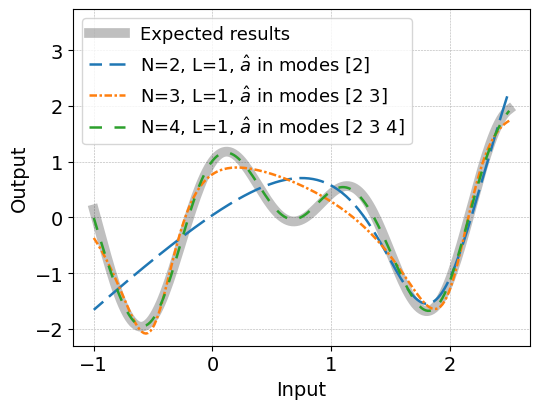

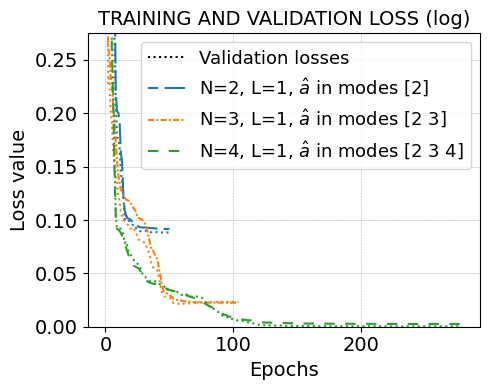

=== ACHIEVED TRAINING LOSSES ===
N=2, L=1, $\hat a$ in modes [2]: 0.09598777864666663
N=3, L=1, $\hat a$ in modes [2 3]: 0.022786453441752702
N=4, L=1, $\hat a$ in modes [2 3 4]: 0.0025364381934933258


In [7]:
# === PLOT AND SAVE JOINT RESULTS ===
nongauss_ops_ascii = ["adag" if is_addition else "a" for is_addition in qnns_is_addition]
filename = (
    task_name
    + "_N" + str(qnns_modes)
    + "_L" + str(qnns_layers)
    + "_ph" + str(nongauss_ops_ascii)
    + str(qnns_ladder_modes)
)

plot_qnns_testing(test_dataset[0], test_dataset[1], qnns_preds, legend_labels, filename, top_ylim=output_range[1] + len(qnns)*0.5 + 0.3)
plot_qnns_loglosses(train_losses, valid_losses, legend_labels, filename)

## Next steps

- **Photon addition instead of subtraction:** set `qnns_is_addition = [True, ...]`.
- **Different target function:** replace `target_function = trig_fun` with another callable from `synthetic_datasets`.
- **More thorough optimization:** increase `basinhopping_iters`.
- **Different readout:** set `observable` to another supported observable like 'number' for $\langle \hat a^\dagger a \rangle$.
- **Disable output scaling:** set `out_norm_ranges = [None, ...]`.
